In [ ]:
import os
import numpy as np
from tqdm import tqdm
from scipy.fft import fft, ifft
import MDAnalysis as mda
import argparse


# Load Universe
parser = argparse.ArgumentParser(description="Load MDAnalysis Universe for SAA water system.")
parser.add_argument(
    "-rep",
    dest="rep_num",
    default="E5",
    choices=["E1", "E2", "E3", "E4", "E5"],
    help="Replica label (E1/ E2/ E3/ E4/ E5). Default: E5",
)

# Use parse_known_args so it doesn’t crash in Jupyter
args, _ = parser.parse_known_args()
rep_num = args.rep_num
print(f"Replica: {rep_num}")


SAA = "6MST"
u = mda.Universe(f"/projectnb/gaussden/conor/SAA_Water/{SAA}/rep1/{rep_num}/4.2_production.tpr",
                 f"/projectnb/gaussden/conor/SAA_Water/{SAA}/rep1/{rep_num}/4.2_unwrapped.trr")

# Parameters
nCorr = 500
dt = 0.004  # ps
sigma = 10.0  # cm^-1
f = 25000  # number of frames
output_dir = f"SAA_data/{SAA}"
os.makedirs(output_dir, exist_ok=True)

# Selections to iterate over
selection_files = [
    "select_H2Oin0.npy"
    #, "select_H2Oin1.npy", 
]

# Common atom group
water_oxygen = u.select_atoms("resname TIP3 and name OH2")


# Begin looping over each selection
for sel_file in selection_files:
    print(f"\nProcessing: {sel_file}")
    selection_path = os.path.join(f"/projectnb/gaussden/conor/SAA_Water/{SAA}/rep1/{rep_num}/internal_water", sel_file)
    select_array = np.load(selection_path)

    # Find atomgroup with H for first valid frame
    for ts in u.trajectory[:f]:
        internal_atomgroup = water_oxygen.atoms[select_array[ts.frame, :]].residues.atoms
        if internal_atomgroup.n_atoms > 0:
            break
    nAtoms = internal_atomgroup.n_atoms

/scratch/2683952.1.f/ipykernel_1136812/2563018723.py:8: DeprecationWarning: `hole` is deprecated!
`hole` will be removed in release 3.0.0.
This method has been moved to the MDAKit hole2-mdakit: https://github.com/MDAnalysis/hole2-mdakit
  profiles = hole2.hole(pdb, executable=HOLE_EXE, sample=0.25, end_radius=15.0,


fields: ('rxn_coord', 'radius', 'cen_line_D')


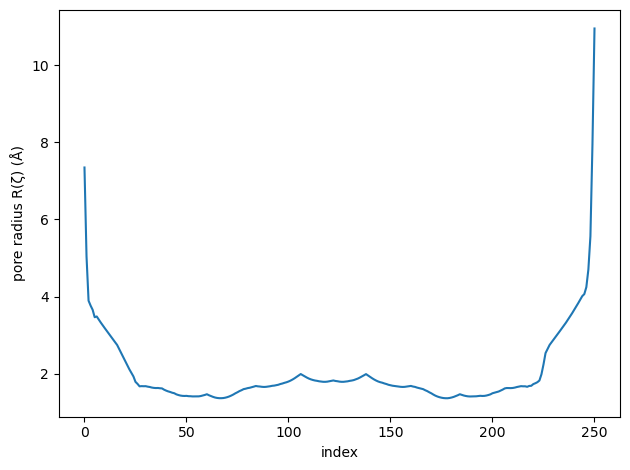

In [6]:
from MDAnalysis.analysis import hole2
import numpy as np
import matplotlib.pyplot as plt

HOLE_EXE = "/projectnb/mcprot/nayaksp/.conda/envs/FRESEAN-python-env/bin/hole"
pdb = "1MAG.pdb"

profiles = hole2.hole(pdb, executable=HOLE_EXE, sample=0.25, end_radius=15.0,
                      cvect=[0, 0, 1])

prof0 = profiles[0]  # frame 0

print("fields:", prof0.dtype.names)

# robust field detection
rfield = "radius" if "radius" in prof0.dtype.names else ("r" if "r" in prof0.dtype.names else None)
zfield = "zeta" if "zeta" in prof0.dtype.names else None

if rfield is None:
    raise RuntimeError(f"No radius field found in {prof0.dtype.names}")

x = prof0[zfield] if zfield else np.arange(len(prof0[rfield]))

plt.plot(x, prof0[rfield])
plt.xlabel("reaction coordinate ζ (Å)" if zfield else "index")
plt.ylabel("pore radius R(ζ) (Å)")
plt.tight_layout()
plt.show()


/scratch/2683952.1.f/ipykernel_1136812/3332168381.py:25: DeprecationWarning: `hole` is deprecated!
`hole` will be removed in release 3.0.0.
This method has been moved to the MDAKit hole2-mdakit: https://github.com/MDAnalysis/hole2-mdakit
  profiles = hole2.hole(


HOLE fields: ('rxn_coord', 'radius', 'cen_line_D')
cen_line_D shape is (257,); not (N,3). Using rxn_coord for y-axis.
Rmin = 1.365 Å at y = -10.296 Å


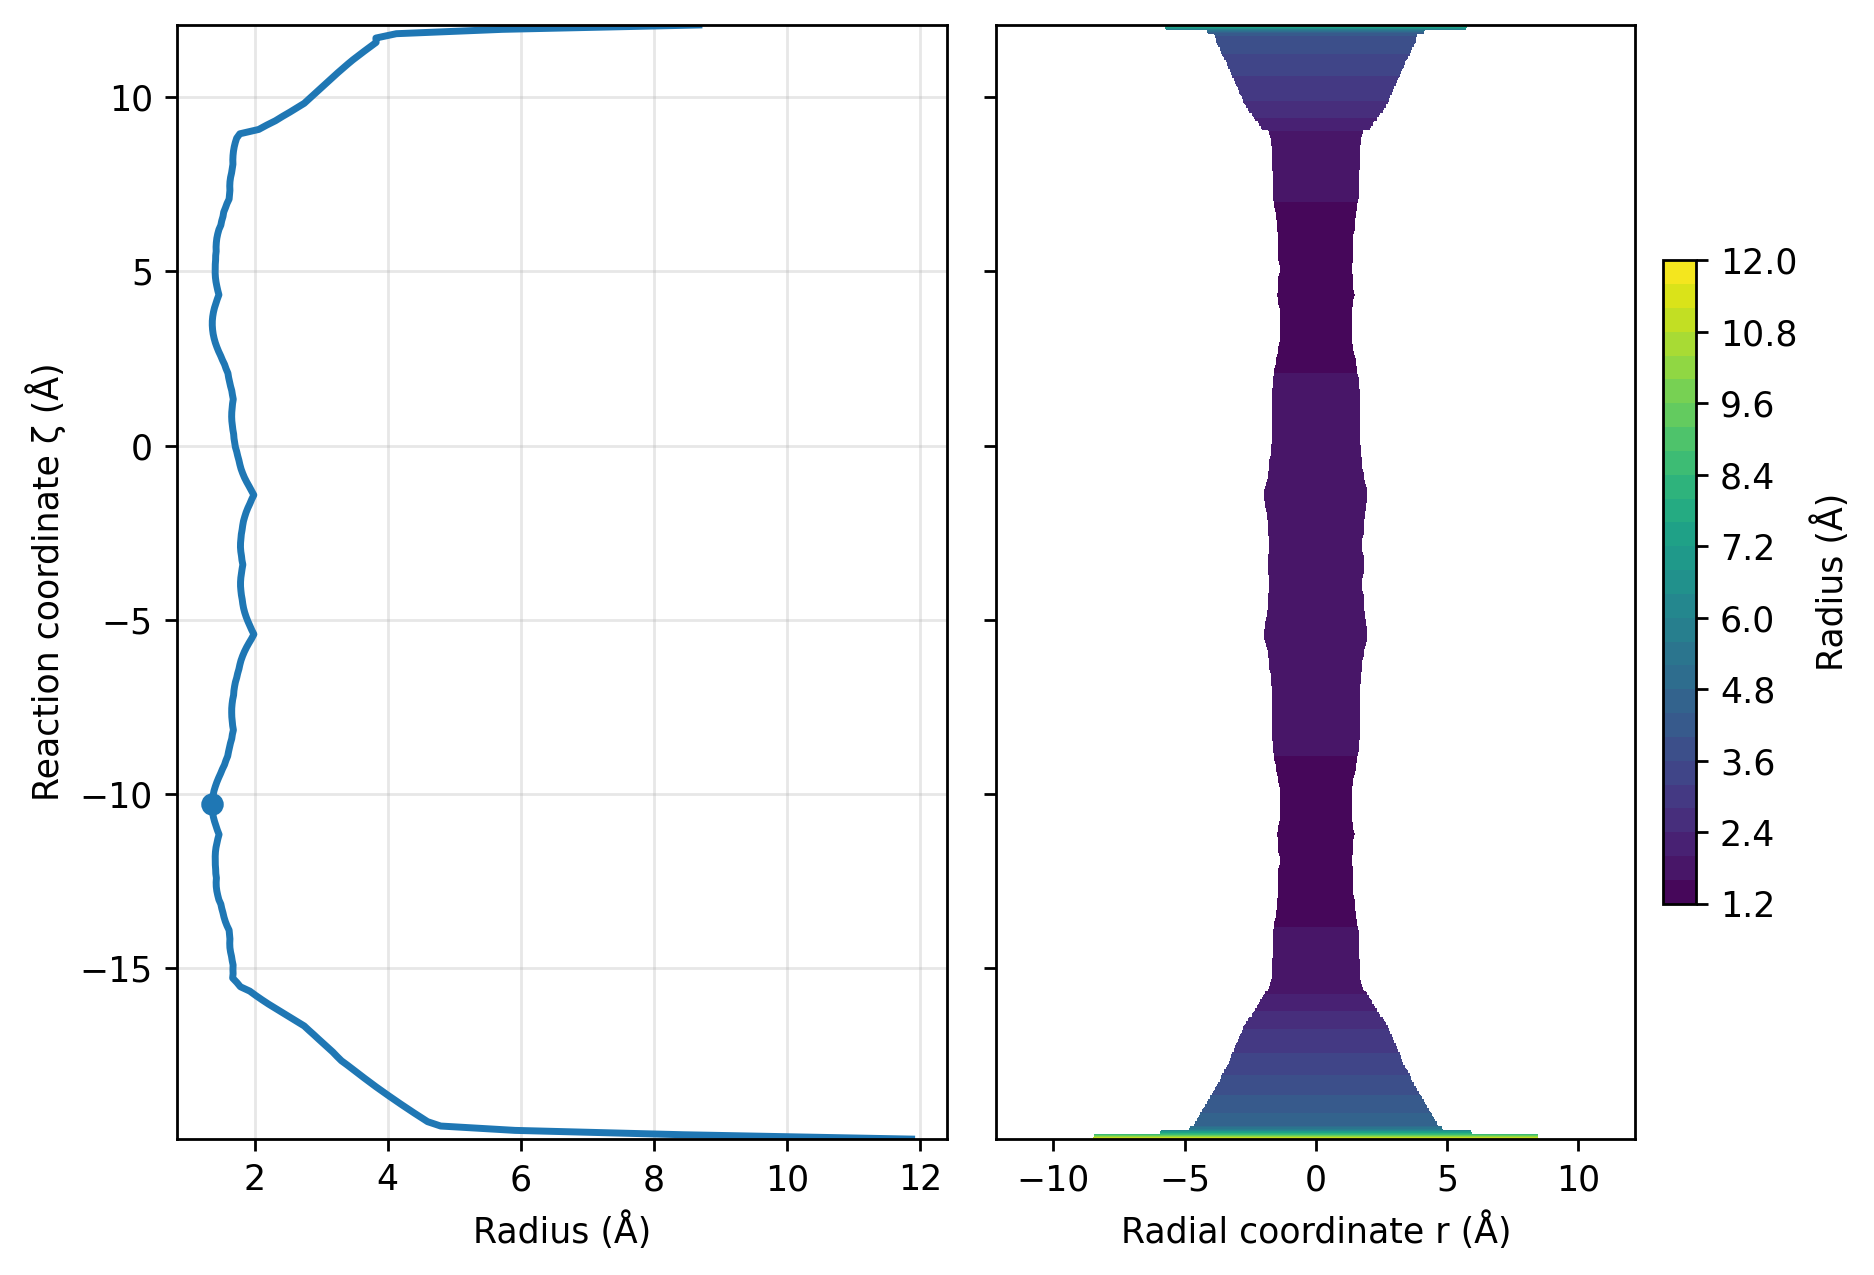

In [14]:
from MDAnalysis.analysis import hole2
import numpy as np
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
HOLE_EXE = "/projectnb/mcprot/nayaksp/.conda/envs/FRESEAN-python-env/bin/hole"
pdb = "1MAG.pdb"

# Optional: annotate axial regions (set to [] to disable)
# These are in the same units as the y-axis you choose (rxn_coord or arclength)
REGIONS = [
    # (ymin, ymax, label, alpha)
    # Example placeholders; edit to match your protein
    # (13, 18, "NPA", 0.20),
    # (20, 25, "Constriction region", 0.15),
]

USE_ARCLENGTH_IF_POSSIBLE = True  # uses cen_line_D to build distance along centerline if shape is (N,3)

# =========================
# RUN HOLE
# =========================
profiles = hole2.hole(
    pdb,
    executable=HOLE_EXE,
    sample=0.25,
    end_radius=15.0,
    cvect=[0, 0, 1],
)
prof = profiles[0]
fields = prof.dtype.names
print("HOLE fields:", fields)

# Known fields from your output
z = np.asarray(prof["rxn_coord"], float)
R = np.asarray(prof["radius"], float)

# =========================
# SORT BY AXIAL COORD
# =========================
order = np.argsort(z)
z = z[order]
R = R[order]

# =========================
# OPTIONALLY BUILD TRUE ARCLENGTH AXIS FROM CENTERLINE
# =========================
y = z
y_label = "Reaction coordinate ζ (Å)"

if USE_ARCLENGTH_IF_POSSIBLE and ("cen_line_D" in fields):
    C = np.asarray(prof["cen_line_D"])
    # Try to interpret as XYZ centerline coordinates
    if C.ndim == 2 and C.shape[0] == len(R) and C.shape[1] == 3:
        C = C[order]
        ds = np.linalg.norm(np.diff(C, axis=0), axis=1)
        s = np.concatenate([[0.0], np.cumsum(ds)])
        y = s
        y_label = "Centerline arclength s (Å)"
        print("Using centerline arclength axis from cen_line_D.")
    else:
        print(f"cen_line_D shape is {C.shape}; not (N,3). Using rxn_coord for y-axis.")

# =========================
# BUILD 2D "TUBE" MAP
# =========================
def tube_map(y, R, nr=501, pad=0.30):
    """
    Create a 2D field val(y,r) that is defined inside the pore:
      val = R(y) for |r| <= R(y)
      val = NaN outside (blank)
    """
    rmax = float(np.nanmax(R) + pad)
    rgrid = np.linspace(-rmax, rmax, nr)
    ygrid = y.copy()

    abs_r = np.abs(rgrid)[None, :]    # (1, nr)
    Rrow  = R[:, None]                # (ny, 1)

    # Full field then mask outside pore
    val = np.broadcast_to(Rrow, (len(ygrid), len(rgrid))).astype(float)
    val[abs_r > Rrow] = np.nan
    return rgrid, ygrid, val

rgrid, ygrid, val = tube_map(y, R, nr=501, pad=0.30)

# =========================
# BASIC METRICS
# =========================
imin = int(np.nanargmin(R))
print(f"Rmin = {R[imin]:.3f} Å at y = {y[imin]:.3f} Å")

# =========================
# PLOTTING: PROFILE + TUBE
# =========================
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(7.6, 5.2), dpi=250,
    gridspec_kw={"width_ratios": [1.10, 1.0]},
    sharey=True
)

# Left: radius profile (Radius on x, axial on y)
ax1.plot(R, y, lw=2)
ax1.scatter([R[imin]], [y[imin]], s=30, zorder=5)
ax1.set_xlabel("Radius (Å)")
ax1.set_ylabel(y_label)
ax1.grid(True, alpha=0.30)

# Optional shaded regions
if REGIONS:
    x0, x1 = ax1.get_xlim()
    for ymin, ymax, lab, a in REGIONS:
        ax1.axhspan(ymin, ymax, alpha=a)
        ax1.text(x0 + 0.03*(x1-x0), 0.5*(ymin+ymax), lab, va="center", ha="left")

# Right: tube heatmap
levels = 30
cf = ax2.contourf(rgrid, ygrid, val, levels=levels)
ax2.set_xlabel("Radial coordinate r (Å)")
ax2.set_xlim(rgrid.min(), rgrid.max())

# Make it look more "tube-like"
ax2.set_aspect("auto")

cbar = fig.colorbar(cf, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label("Radius (Å)")

plt.tight_layout()
plt.show()


/scratch/2683952.1.f/ipykernel_1136812/1718546299.py:117: DeprecationWarning: `hole` is deprecated!
`hole` will be removed in release 3.0.0.
This method has been moved to the MDAKit hole2-mdakit: https://github.com/MDAnalysis/hole2-mdakit
  profs = hole2.hole(


=== HOLE sanity summary ===
Tests run: 54 | successful: 54
Rmin range across successful tests: 0.006 Å
z@Rmin range across successful tests: 288.000 Å

Top 15 rows:
   Rmin  zmin     L  Rend_left  Rend_right  open_frac                      cvect  sample  end_radius issues
1.36491 304.0 418.0   14.29634    15.23177   0.937947            (0.0, 0.0, 1.0)    0.15        20.0       
1.36199 126.0 420.0   16.32900    17.38146   0.938242  (0.099504, 0.0, 0.995037)    0.15        20.0       
1.36400 288.0 402.0   15.90158    12.53016   0.940447 (-0.099504, 0.0, 0.995037)    0.15        20.0       
1.36129 318.0 448.0   16.54956    16.92810   0.942094  (0.0, 0.099504, 0.995037)    0.15        20.0       
1.36398 280.0 380.0   12.95093    15.07693   0.934383 (0.0, -0.099504, 0.995037)    0.15        20.0       
1.36342 307.0 410.0   12.17281    19.46617   0.941606  (0.196116, 0.0, 0.980581)    0.15        20.0       
1.36024  77.0 266.0   11.92110    18.91121   0.940075            (0.0, 0.0, 1.0

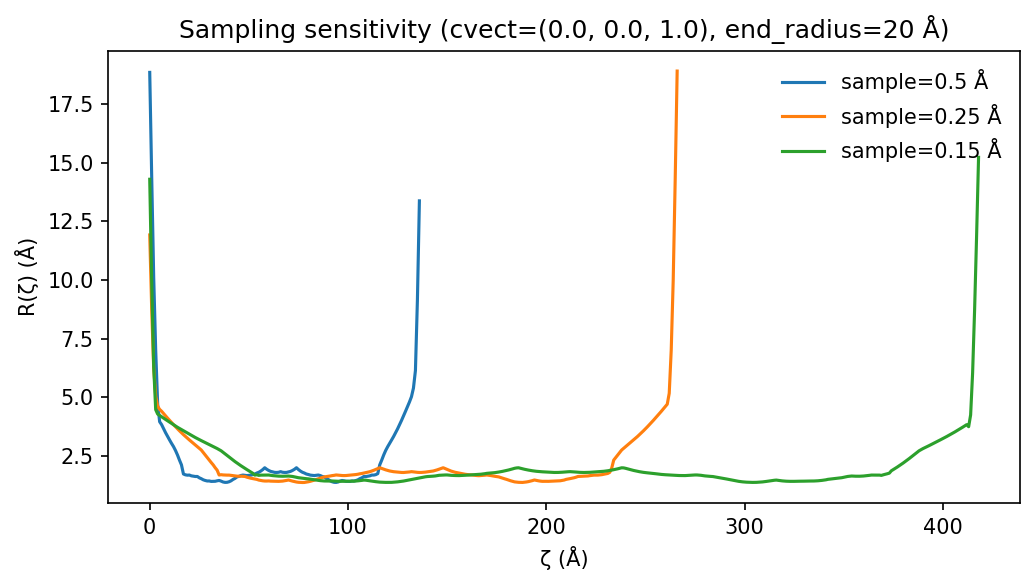

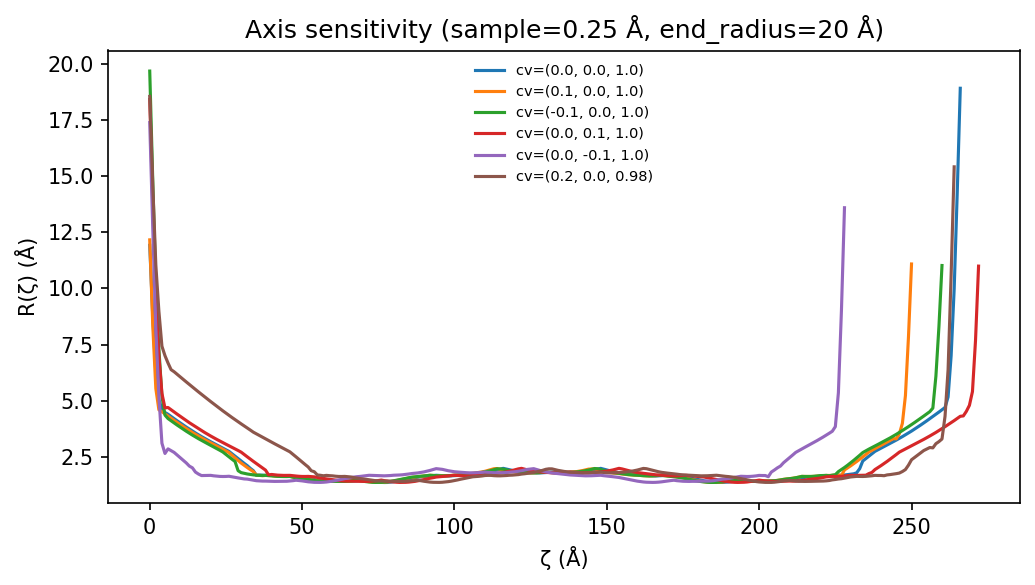

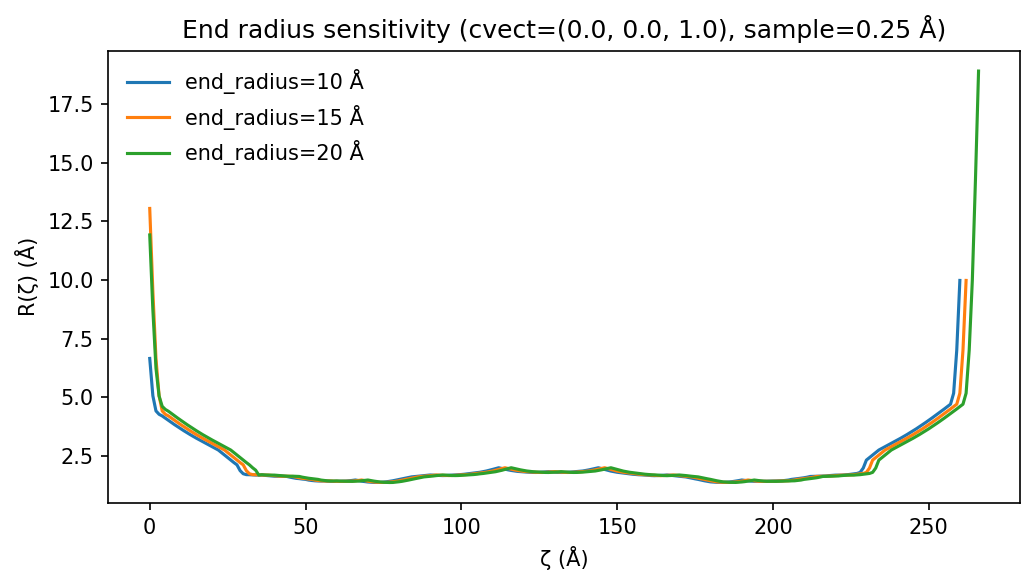

In [9]:
"""
HOLE (MDAnalysis.analysis.hole2) sanity / sensitivity checks

What it does:
  1) Varies cvect (axis), sample (grid spacing), and end_radius
  2) Extracts robust metrics: Rmin, z_at_Rmin, profile length, end radii, "open fraction"
  3) Flags potential issues:
       - profile truncation (ends not wide enough)
       - bottleneck instability across parameter choices
       - noisy profiles (too-coarse sampling)
  4) Makes overlay plots (radius profiles) for quick visual sanity

Assumes:
  - You have a working HOLE executable and a PDB (or HOLE-readable input).
"""

from MDAnalysis.analysis import hole2
import numpy as np
import matplotlib.pyplot as plt

try:
    import pandas as pd
except ImportError:
    pd = None

# -------------------------
# USER SETTINGS
# -------------------------
HOLE_EXE = "/projectnb/mcprot/nayaksp/.conda/envs/FRESEAN-python-env/bin/hole"
pdb = "1MAG.pdb"

# Thresholds for sanity flags (tune as needed)
R_END_OK = 8.0          # Å : if ends are < this, profile might be truncated inside protein
R_OPEN_CUT = 1.4        # Å : "open to water-ish" heuristic
BOTTLENECK_TOL = 0.3     # Å : if Rmin shifts more than this across tests, axis/params are sensitive
ZSHIFT_TOL = 3.0         # Å : if z_at_Rmin shifts more than this across tests, bottleneck location unstable

# Parameter grids to test
cvects = [
    np.array([0.0, 0.0, 1.0]),
    np.array([0.1, 0.0, 1.0]),
    np.array([-0.1, 0.0, 1.0]),
    np.array([0.0, 0.1, 1.0]),
    np.array([0.0, -0.1, 1.0]),
    np.array([0.2, 0.0, 1.0]),
]
samples = [0.5, 0.25, 0.15]
end_radii = [10.0, 15.0, 20.0]

# -------------------------
# Helpers
# -------------------------
def _norm(v):
    v = np.asarray(v, float)
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def _detect_fields(prof):
    names = prof.dtype.names
    rfield = "radius" if "radius" in names else ("r" if "r" in names else None)
    zfield = "zeta" if "zeta" in names else ("s" if "s" in names else None)  # sometimes "s"
    if rfield is None:
        raise RuntimeError(f"No radius-like field in {names}")
    return rfield, zfield

def _profile_xy(prof):
    rfield, zfield = _detect_fields(prof)
    r = np.asarray(prof[rfield], float)
    if zfield is not None:
        z = np.asarray(prof[zfield], float)
    else:
        z = np.arange(len(r), dtype=float)
    # clean NaNs if any
    m = np.isfinite(r) & np.isfinite(z)
    return z[m], r[m]

def _metrics_from_profile(z, r, open_cut=R_OPEN_CUT):
    if len(r) == 0:
        return dict(Rmin=np.nan, zmin=np.nan, L=np.nan, Rend_left=np.nan, Rend_right=np.nan,
                    open_frac=np.nan)

    i_min = int(np.nanargmin(r))
    Rmin = float(r[i_min])
    zmin = float(z[i_min])

    # Estimate length along z (only meaningful if z is Å)
    L = float(np.nanmax(z) - np.nanmin(z)) if len(z) > 1 else 0.0

    Rend_left = float(r[0])
    Rend_right = float(r[-1])
    open_frac = float(np.mean(r > open_cut))

    return dict(Rmin=Rmin, zmin=zmin, L=L, Rend_left=Rend_left, Rend_right=Rend_right,
                open_frac=open_frac)

def _issue_flags(m):
    flags = []
    if np.isfinite(m["Rend_left"]) and m["Rend_left"] < R_END_OK:
        flags.append(f"left_end<{R_END_OK:g}Å")
    if np.isfinite(m["Rend_right"]) and m["Rend_right"] < R_END_OK:
        flags.append(f"right_end<{R_END_OK:g}Å")
    return ",".join(flags) if flags else ""

# -------------------------
# Run sensitivity sweep
# -------------------------
results = []
profiles_cache = {}  # store (z,r) for plotting by key

for cv in cvects:
    cv = _norm(cv)
    for smp in samples:
        for er in end_radii:
            key = (tuple(np.round(cv, 6)), smp, er)

            try:
                profs = hole2.hole(
                    pdb,
                    executable=HOLE_EXE,
                    sample=float(smp),
                    end_radius=float(er),
                    cvect=cv.tolist(),
                )
                prof0 = profs[0]  # first frame
                z, r = _profile_xy(prof0)
                m = _metrics_from_profile(z, r)
                m.update(dict(cvect=key[0], sample=smp, end_radius=er, issues=_issue_flags(m)))
                results.append(m)
                profiles_cache[key] = (z, r)

            except Exception as e:
                results.append(dict(
                    cvect=key[0], sample=smp, end_radius=er,
                    Rmin=np.nan, zmin=np.nan, L=np.nan,
                    Rend_left=np.nan, Rend_right=np.nan, open_frac=np.nan,
                    issues=f"ERROR:{type(e).__name__}"
                ))

# -------------------------
# Summarize stability of bottleneck
# -------------------------
Rmins = np.array([r["Rmin"] for r in results], float)
zmins = np.array([r["zmin"] for r in results], float)
good = np.isfinite(Rmins) & np.isfinite(zmins)

Rmin_range = float(np.nanmax(Rmins[good]) - np.nanmin(Rmins[good])) if np.any(good) else np.nan
zmin_range = float(np.nanmax(zmins[good]) - np.nanmin(zmins[good])) if np.any(good) else np.nan

print("=== HOLE sanity summary ===")
print(f"Tests run: {len(results)} | successful: {int(np.sum(good))}")
print(f"Rmin range across successful tests: {Rmin_range:.3f} Å")
print(f"z@Rmin range across successful tests: {zmin_range:.3f} Å")
if np.isfinite(Rmin_range) and Rmin_range > BOTTLENECK_TOL:
    print(f"WARNING: Rmin varies > {BOTTLENECK_TOL:g} Å across settings (axis/params sensitive).")
if np.isfinite(zmin_range) and zmin_range > ZSHIFT_TOL:
    print(f"WARNING: bottleneck location shifts > {ZSHIFT_TOL:g} Å across settings.")

# -------------------------
# Print / show results table
# -------------------------
if pd is not None:
    df = pd.DataFrame(results)
    # compact formatting: show best (largest end_radius, smallest sample) first
    df = df.sort_values(["end_radius", "sample"], ascending=[False, True]).reset_index(drop=True)
    print("\nTop 15 rows:")
    print(df.head(15).to_string(index=False))
else:
    print("\nInstall pandas for a nicer table; printing raw dicts:")
    for r in results[:10]:
        print(r)

# -------------------------
# Quick overlay plots
# -------------------------
# 1) Overlay by sample (fix end_radius at max, cvect at first)
cv_ref = _norm(cvects[0])
er_ref = max(end_radii)

plt.figure(figsize=(7, 4), dpi=150)
for smp in samples:
    key = (tuple(np.round(cv_ref, 6)), smp, er_ref)
    if key in profiles_cache:
        z, r = profiles_cache[key]
        plt.plot(z, r, label=f"sample={smp:g} Å")
plt.title(f"Sampling sensitivity (cvect={tuple(np.round(cv_ref,3))}, end_radius={er_ref:g} Å)")
plt.xlabel("ζ (Å)"); plt.ylabel("R(ζ) (Å)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# 2) Overlay by cvect (fix sample at middle, end_radius at max)
smp_ref = 0.25 if 0.25 in samples else samples[len(samples)//2]

plt.figure(figsize=(7, 4), dpi=150)
for cv in cvects:
    cvn = _norm(cv)
    key = (tuple(np.round(cvn, 6)), smp_ref, er_ref)
    if key in profiles_cache:
        z, r = profiles_cache[key]
        plt.plot(z, r, label=f"cv={tuple(np.round(cvn,2))}")
plt.title(f"Axis sensitivity (sample={smp_ref:g} Å, end_radius={er_ref:g} Å)")
plt.xlabel("ζ (Å)"); plt.ylabel("R(ζ) (Å)")
plt.legend(fontsize=7, frameon=False)
plt.tight_layout()
plt.show()

# 3) Overlay by end_radius (fix sample and cvect)
plt.figure(figsize=(7, 4), dpi=150)
for er in end_radii:
    key = (tuple(np.round(cv_ref, 6)), smp_ref, er)
    if key in profiles_cache:
        z, r = profiles_cache[key]
        plt.plot(z, r, label=f"end_radius={er:g} Å")
plt.title(f"End radius sensitivity (cvect={tuple(np.round(cv_ref,3))}, sample={smp_ref:g} Å)")
plt.xlabel("ζ (Å)"); plt.ylabel("R(ζ) (Å)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [10]:
def z_from_index(n, sample):
    return np.arange(n, dtype=float) * float(sample)  # Å-ish coordinate


/scratch/2683952.1.f/ipykernel_1136812/4017540509.py:127: DeprecationWarning: `hole` is deprecated!
`hole` will be removed in release 3.0.0.
This method has been moved to the MDAKit hole2-mdakit: https://github.com/MDAnalysis/hole2-mdakit
  profs = hole2.hole(


=== HOLE sanity summary (updated) ===
Tests run: 54 | successful: 54
Rmin range across successful tests: 0.006 Å
zfrac range across successful tests: 0.501 (unitless)
True-z (zeta/s) not available in profile fields; using z = index*sample and zfrac.

Top 20 rows:
   Rmin  zmin    zfrac    L  Rend_left  Rend_right  open_frac                      cvect  sample  end_radius  z_is_true issues
1.36098 16.80 0.275862 60.9   17.49804    19.72545   0.936118            (0.0, 0.0, 1.0)    0.15        20.0      False       
1.36365 17.40 0.290000 60.0   14.96809    17.21940   0.935162  (0.099504, 0.0, 0.995037)    0.15        20.0      False       
1.36102 43.20 0.712871 60.6   18.12775    16.65325   0.935802 (-0.099504, 0.0, 0.995037)    0.15        20.0      False       
1.36297 46.80 0.693333 67.5   13.15109    12.49571   0.942350  (0.0, 0.099504, 0.995037)    0.15        20.0      False       
1.35963 14.70 0.257895 57.0   19.88493    17.14516   0.931759 (0.0, -0.099504, 0.995037)    0.15     

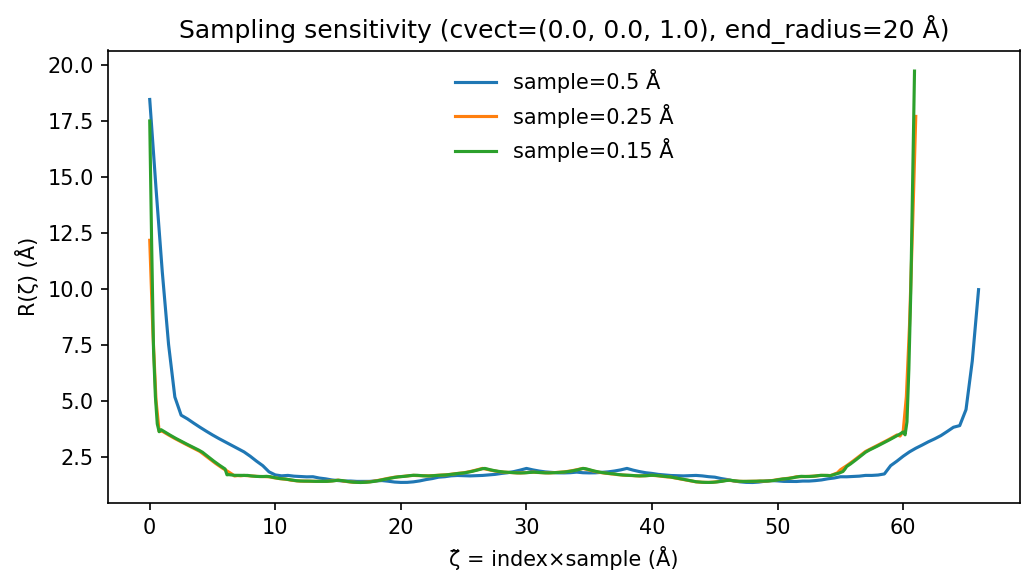

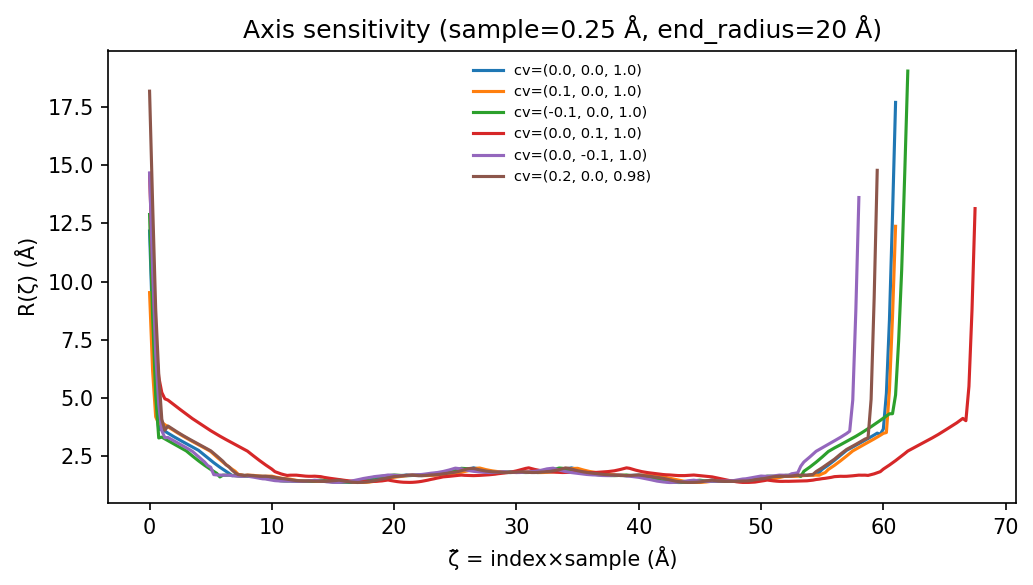

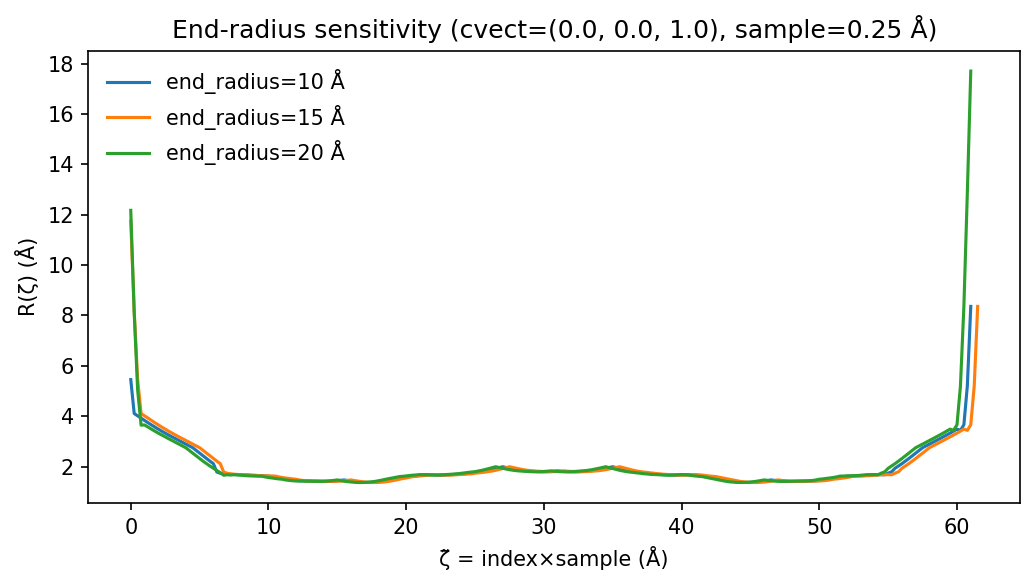

In [11]:
"""
UPDATED HOLE sanity / sensitivity checks (fixes the zmin issue)

Key fixes vs earlier version:
  - If HOLE does NOT provide a true reaction coordinate field (zeta/s),
    we build a comparable coordinate: z = index * sample  (Å-like)
  - We also compute zfrac (fractional position along the profile), which
    is always comparable across different sampling/lengths.
  - Stability warning now uses zfrac (and zmin only if it's truly zeta/s).

Outputs:
  - Summary ranges for Rmin, zfrac, and (if available) true zeta-based zmin
  - A results table (pandas if installed)
  - Overlay plots for sample / axis / end_radius sensitivity

Author: drop-in script for your environment
"""

from MDAnalysis.analysis import hole2
import numpy as np
import matplotlib.pyplot as plt

try:
    import pandas as pd
except ImportError:
    pd = None

# -------------------------
# USER SETTINGS
# -------------------------
HOLE_EXE = "/projectnb/mcprot/nayaksp/.conda/envs/FRESEAN-python-env/bin/hole"
pdb = "1MAG.pdb"

# Sanity thresholds (tune as desired)
R_END_OK = 8.0          # Å : if ends are < this, profile might be truncated inside protein
R_OPEN_CUT = 1.4        # Å : "open to water-ish" heuristic
RMIN_TOL = 0.3          # Å : Rmin sensitivity warning threshold
ZFRAC_TOL = 0.05        # unitless fraction: bottleneck position stability threshold

# Parameter grids to test
cvects = [
    np.array([0.0, 0.0, 1.0]),
    np.array([0.1, 0.0, 1.0]),
    np.array([-0.1, 0.0, 1.0]),
    np.array([0.0, 0.1, 1.0]),
    np.array([0.0, -0.1, 1.0]),
    np.array([0.2, 0.0, 1.0]),
]
samples = [0.5, 0.25, 0.15]
end_radii = [10.0, 15.0, 20.0]

# -------------------------
# Helpers
# -------------------------
def _norm(v):
    v = np.asarray(v, float)
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def _detect_fields(prof):
    """Return (rfield, zfield_or_None) with robust detection."""
    names = prof.dtype.names
    rfield = "radius" if "radius" in names else ("r" if "r" in names else None)
    # Some builds provide "zeta", some "s"; many provide neither.
    zfield = "zeta" if "zeta" in names else ("s" if "s" in names else None)
    if rfield is None:
        raise RuntimeError(f"No radius-like field in {names}")
    return rfield, zfield

def _profile_xy(prof, sample):
    """
    Returns z, r, z_is_true (bool)
      - If zeta/s exists: z is HOLE reaction coordinate (true)
      - Else: z := index * sample (Å-like, comparable across samples)
    """
    rfield, zfield = _detect_fields(prof)
    r = np.asarray(prof[rfield], float)

    if zfield is not None:
        z = np.asarray(prof[zfield], float)
        z_is_true = True
    else:
        z = np.arange(len(r), dtype=float) * float(sample)
        z_is_true = False

    m = np.isfinite(r) & np.isfinite(z)
    return z[m], r[m], z_is_true

def _metrics_from_profile(z, r, open_cut=R_OPEN_CUT):
    if len(r) == 0:
        return dict(Rmin=np.nan, zmin=np.nan, zfrac=np.nan, L=np.nan,
                    Rend_left=np.nan, Rend_right=np.nan, open_frac=np.nan)

    i_min = int(np.nanargmin(r))
    Rmin = float(r[i_min])
    zmin = float(z[i_min])
    zfrac = float(i_min / (len(r) - 1)) if len(r) > 1 else np.nan

    L = float(z[-1] - z[0]) if len(z) > 1 else 0.0
    Rend_left = float(r[0])
    Rend_right = float(r[-1])
    open_frac = float(np.mean(r > open_cut))

    return dict(Rmin=Rmin, zmin=zmin, zfrac=zfrac, L=L,
                Rend_left=Rend_left, Rend_right=Rend_right, open_frac=open_frac)

def _issue_flags(m):
    flags = []
    if np.isfinite(m["Rend_left"]) and m["Rend_left"] < R_END_OK:
        flags.append(f"left_end<{R_END_OK:g}Å")
    if np.isfinite(m["Rend_right"]) and m["Rend_right"] < R_END_OK:
        flags.append(f"right_end<{R_END_OK:g}Å")
    return ",".join(flags) if flags else ""

# -------------------------
# Run sensitivity sweep
# -------------------------
results = []
profiles_cache = {}  # key -> (z,r,z_is_true)

for cv in cvects:
    cvn = _norm(cv)
    for smp in samples:
        for er in end_radii:
            key = (tuple(np.round(cvn, 6)), float(smp), float(er))
            try:
                profs = hole2.hole(
                    pdb,
                    executable=HOLE_EXE,
                    sample=float(smp),
                    end_radius=float(er),
                    cvect=cvn.tolist(),
                )
                prof0 = profs[0]
                z, r, z_is_true = _profile_xy(prof0, sample=smp)
                m = _metrics_from_profile(z, r)
                m.update(dict(
                    cvect=key[0], sample=smp, end_radius=er,
                    z_is_true=z_is_true,
                    issues=_issue_flags(m)
                ))
                results.append(m)
                profiles_cache[key] = (z, r, z_is_true)

            except Exception as e:
                results.append(dict(
                    cvect=key[0], sample=smp, end_radius=er, z_is_true=False,
                    Rmin=np.nan, zmin=np.nan, zfrac=np.nan, L=np.nan,
                    Rend_left=np.nan, Rend_right=np.nan, open_frac=np.nan,
                    issues=f"ERROR:{type(e).__name__}"
                ))

# -------------------------
# Summaries
# -------------------------
Rmins = np.array([r["Rmin"] for r in results], float)
zfracs = np.array([r["zfrac"] for r in results], float)

good = np.isfinite(Rmins) & np.isfinite(zfracs)
Rmin_range = float(np.nanmax(Rmins[good]) - np.nanmin(Rmins[good])) if np.any(good) else np.nan
zfrac_range = float(np.nanmax(zfracs[good]) - np.nanmin(zfracs[good])) if np.any(good) else np.nan

# Also compute zmin range ONLY for true z coordinates (if any)
true_mask = np.array([bool(r.get("z_is_true", False)) for r in results])
zmins_true = np.array([r["zmin"] for r in results], float)
good_true = true_mask & np.isfinite(zmins_true)
zmin_true_range = float(np.nanmax(zmins_true[good_true]) - np.nanmin(zmins_true[good_true])) if np.any(good_true) else np.nan

print("=== HOLE sanity summary (updated) ===")
print(f"Tests run: {len(results)} | successful: {int(np.sum(good))}")
print(f"Rmin range across successful tests: {Rmin_range:.3f} Å")
print(f"zfrac range across successful tests: {zfrac_range:.3f} (unitless)")
if np.any(good_true):
    print(f"True-z (zeta/s) z@Rmin range: {zmin_true_range:.3f} Å  (only where zeta/s exists)")
else:
    print("True-z (zeta/s) not available in profile fields; using z = index*sample and zfrac.")

if np.isfinite(Rmin_range) and Rmin_range > RMIN_TOL:
    print(f"WARNING: Rmin varies > {RMIN_TOL:g} Å across settings (axis/params sensitive).")
if np.isfinite(zfrac_range) and zfrac_range > ZFRAC_TOL:
    print(f"WARNING: bottleneck fractional position varies > {ZFRAC_TOL:g} across settings.")

# -------------------------
# Table
# -------------------------
if pd is not None:
    df = pd.DataFrame(results)
    df = df.sort_values(["end_radius", "sample"], ascending=[False, True]).reset_index(drop=True)
    print("\nTop 20 rows:")
    cols = ["Rmin", "zmin", "zfrac", "L", "Rend_left", "Rend_right", "open_frac",
            "cvect", "sample", "end_radius", "z_is_true", "issues"]
    print(df[cols].head(20).to_string(index=False))
else:
    print("\nInstall pandas for a nicer table; showing first 10 rows:")
    for r in results[:10]:
        print(r)

# -------------------------
# Overlay plots
# -------------------------
cv_ref = _norm(cvects[0])
er_ref = max(end_radii)

# (1) Sampling sensitivity: vary sample at fixed cvect, end_radius
plt.figure(figsize=(7, 4), dpi=150)
for smp in samples:
    key = (tuple(np.round(cv_ref, 6)), float(smp), float(er_ref))
    if key in profiles_cache:
        z, r, z_is_true = profiles_cache[key]
        xlab = "ζ (Å)" if z_is_true else "ζ̃ = index×sample (Å)"
        plt.plot(z, r, label=f"sample={smp:g} Å")
plt.title(f"Sampling sensitivity (cvect={tuple(np.round(cv_ref,3))}, end_radius={er_ref:g} Å)")
plt.xlabel(xlab); plt.ylabel("R(ζ) (Å)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# (2) Axis sensitivity: vary cvect at fixed sample, end_radius
smp_ref = 0.25 if 0.25 in samples else samples[len(samples)//2]
plt.figure(figsize=(7, 4), dpi=150)
for cv in cvects:
    cvn = _norm(cv)
    key = (tuple(np.round(cvn, 6)), float(smp_ref), float(er_ref))
    if key in profiles_cache:
        z, r, z_is_true = profiles_cache[key]
        xlab = "ζ (Å)" if z_is_true else "ζ̃ = index×sample (Å)"
        plt.plot(z, r, label=f"cv={tuple(np.round(cvn,2))}")
plt.title(f"Axis sensitivity (sample={smp_ref:g} Å, end_radius={er_ref:g} Å)")
plt.xlabel(xlab); plt.ylabel("R(ζ) (Å)")
plt.legend(fontsize=7, frameon=False)
plt.tight_layout()
plt.show()

# (3) End radius sensitivity: vary end_radius at fixed cvect, sample
plt.figure(figsize=(7, 4), dpi=150)
for er in end_radii:
    key = (tuple(np.round(cv_ref, 6)), float(smp_ref), float(er))
    if key in profiles_cache:
        z, r, z_is_true = profiles_cache[key]
        xlab = "ζ (Å)" if z_is_true else "ζ̃ = index×sample (Å)"
        plt.plot(z, r, label=f"end_radius={er:g} Å")
plt.title(f"End-radius sensitivity (cvect={tuple(np.round(cv_ref,3))}, sample={smp_ref:g} Å)")
plt.xlabel(xlab); plt.ylabel("R(ζ) (Å)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [12]:
import numpy as np

def _resample_to_unit(z, r, n=400):
    """Resample r(z) onto a common 0..1 grid using linear interp on normalized z."""
    z = np.asarray(z, float)
    r = np.asarray(r, float)
    # normalize coordinate to 0..1
    zz = (z - z.min()) / (z.max() - z.min() + 1e-12)
    grid = np.linspace(0.0, 1.0, n)
    rr = np.interp(grid, zz, r)
    return grid, rr

def _cos_sim(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    a = a - np.mean(a); b = b - np.mean(b)
    na = np.linalg.norm(a); nb = np.linalg.norm(b)
    if na < 1e-12 or nb < 1e-12:
        return -np.inf
    return float(np.dot(a, b) / (na * nb))

# pick a reference profile (use your "most standard" setting)
cv_ref = tuple(np.round(np.array([0.0, 0.0, 1.0]), 6))
smp_ref = 0.25
er_ref = 20.0

ref_key = (cv_ref, float(smp_ref), float(er_ref))
if ref_key not in profiles_cache:
    # fall back to the first cached profile
    ref_key = next(iter(profiles_cache.keys()))

z_ref, r_ref, _ = profiles_cache[ref_key]
_, r_ref_u = _resample_to_unit(z_ref, r_ref, n=500)

# now orient every profile to match the reference
flipped = 0
zfrac_oriented = []

for (cvect, smp, er), (z, r, _) in profiles_cache.items():
    _, r_u = _resample_to_unit(z, r, n=500)
    sim_fwd = _cos_sim(r_u, r_ref_u)
    sim_rev = _cos_sim(r_u[::-1], r_ref_u)

    use_rev = sim_rev > sim_fwd
    if use_rev:
        flipped += 1
        r_use = r[::-1]
        z_use = z[::-1]
    else:
        r_use = r
        z_use = z

    i_min = int(np.nanargmin(r_use))
    zfrac = i_min / (len(r_use) - 1) if len(r_use) > 1 else np.nan
    zfrac_oriented.append(zfrac)

zfrac_oriented = np.array(zfrac_oriented, float)
good = np.isfinite(zfrac_oriented)

print("=== Orientation sanity ===")
print(f"Reference key used: {ref_key}")
print(f"Profiles flipped to match reference: {flipped} / {len(profiles_cache)}")
print(f"zfrac range AFTER orientation: {np.nanmax(zfrac_oriented[good]) - np.nanmin(zfrac_oriented[good]):.3f}")
print(f"zfrac mean ± std AFTER orientation: {np.nanmean(zfrac_oriented[good]):.3f} ± {np.nanstd(zfrac_oriented[good]):.3f}")


=== Orientation sanity ===
Reference key used: ((0.0, 0.0, 1.0), 0.25, 20.0)
Profiles flipped to match reference: 31 / 54
zfrac range AFTER orientation: 0.502
zfrac mean ± std AFTER orientation: 0.443 ± 0.216
